# Tổng quan học máy (Phần 2)

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings as warning
warning.filterwarnings('ignore')

## Tiền xử lý (biến đổi dữ liệu)

Sau khi chuẩn bị dữ liệu và trước khi tiến hành các thuật toán học máy, ta thường **tiền xử lý** (preprocessing) dữ liệu, tức là **biến đổi** (transform) dữ liệu về dạng phù hợp. Bước này thường được gọi là **feature engineering**.

Chẳng hạn các việc tiền xử lý hay gặp là:
- Xử lý **dữ liệu bị thiếu** (missing data).
- Biến đổi các đặc trưng thành số, chẳng hạn biến các **biến phân loại** (categorical variable) thành **biến số** (numerical variable) (như giới tính với các giá trị nam, nữ thành 0, 1).
- Thêm các **đặc trưng dẫn xuất** (derived feature) tức là tạo thêm các đặc trưng từ các đặc trưng đã có.
- Loại bỏ bớt hay **chọn lựa đặc trưng** (feature selection) tốt.
- ...

Ví dụ, ta dùng bộ dữ liệu `Titanic Dataset` để dự đoán việc sống chết (survived) theo sex, age và passengerClass.

In [2]:
titanic = pd.read_csv("TitanicSurvival.csv")
titanic

,Unnamed: 0,survived,sex,age,passengerClass
0,"Allen, Miss. Elisabeth Walton",yes,female,29.0000,1st
1,"Allison, Master. Hudson Trevor",yes,male,0.9167,1st
2,"Allison, Miss. Helen Loraine",no,female,2.0000,1st
3,"Allison, Mr. Hudson Joshua Crei",no,male,30.0000,1st
4,"Allison, Mrs. Hudson J C (Bessi",no,female,25.0000,1st
...,...,...,...,...,...
1304,"Zabour, Miss. Hileni",no,female,14.5000,3rd
1305,"Zabour, Miss. Thamine",no,female,NaN,3rd
1306,"Zakarian, Mr. Mapriededer",no,male,26.5000,3rd
1307,"Zakarian, Mr. Ortin",no,male,27.0000,3rd


In [3]:
try:
    titanic.drop("Unnamed: 0", axis=1, inplace=True)
except:
    pass
titanic

,survived,sex,age,passengerClass
0,yes,female,29.0000,1st
1,yes,male,0.9167,1st
2,no,female,2.0000,1st
3,no,male,30.0000,1st
4,no,female,25.0000,1st
...,...,...,...,...
1304,no,female,14.5000,3rd
1305,no,female,NaN,3rd
1306,no,male,26.5000,3rd
1307,no,male,27.0000,3rd


Tách dữ liệu thành ma trận đặc trưng và vector nhãn lớp.

In [4]:
X_raw = titanic.drop("survived", axis=1).to_numpy()
y = titanic["survived"].to_numpy()

In [5]:
X_raw[:5]

array([['female', 29.0, '1st'],
       ['male', 0.916700006, '1st'],
       ['female', 2.0, '1st'],
       ['male', 30.0, '1st'],
       ['female', 25.0, '1st']], dtype=object)

Ta thấy ma trận đặc trưng có cột 0 và 2 là định tính (còn cột 1 là số).

Ta có thể mã các giá trị định tính thành số bằng cách dùng `OrdinalEncoder` trong `sklearn.preprocessing` (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) hoặc `OneHotEncoder` (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). Xem thêm: https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features.

Hơn nữa vì ma trận chứa lẫn lộn các cột định tính và số nên ta cần chỉ rõ cột để biến đổi bằng cách dùng `ColumnTransformer` trong `sklearn.compose` (https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

trans = ColumnTransformer([("ord_enc", OrdinalEncoder(), [0, 2])], # danh sách transormer (tên, transformer, danh sách cột)
                          remainder="passthrough") # biến đổi cột 0, 2, giữ nguyên các cột còn lại
trans.fit(X_raw)
X = trans.transform(X_raw)

X[:5]

array([[0.0, 0.0, 29.0],
       [1.0, 0.0, 0.916700006],
       [0.0, 0.0, 2.0],
       [1.0, 0.0, 30.0],
       [0.0, 0.0, 25.0]], dtype=object)

In [7]:
trans.named_transformers_["ord_enc"].categories_

[array(['female', 'male'], dtype=object),
 array(['1st', '2nd', '3rd'], dtype=object)]

Ta thấy các cột định tính đã được biến đổi thành cột số (lưu ý thứ tự mới của các cột). Cụ thể: ở cột 0 thì female->0, male->1; ở cột 1 thì 1st->0, 2nd->1, 3rd->2; cột 2 là cột số cũ được giữ nguyên.

Tới đây ta đã biến các đặc trưng thành số. Tuy nhiên dữ liệu vẫn còn chỗ bị khuyết.

In [8]:
titanic.isna().sum()

survived            0
sex                 0
age               263
passengerClass      0
dtype: int64

In [9]:
np.mean(X, axis=0)

array([0.6440030557677616, 1.294881588999236, nan], dtype=object)

Ta thấy bộ dữ liệu bị khuyết nhiều dòng ở cột age. Ta có thể xử lý dữ liệu bị khuyết bằng pandas hay NumPy như đã học, hoặc dùng sklearn để **điền dữ liệu khuyết** (imputation of missing values) (https://scikit-learn.org/stable/modules/impute.html).

Chẳng hạn, ta điền giá trị trung bình (mean) của cột vào các chỗ khuyết trong cột.

In [10]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
X = imp.fit_transform(X)
np.mean(X, axis=0)

array([ 0.64400306,  1.29488159, 29.88113451])

Tới đây, ta đã sẵn sàng để thực hiện việc phân lớp.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

alg = LogisticRegression(max_iter=200)
alg.fit(X_train, y_train)  # huấn luyện mô hình trên dữ liệu huấn luyện
alg.score(X_test, y_test)  # tính accuracy score trên dữ liệu kiểm tra

0.7977099236641222

Ta đã thực hiện nhiều bước trên dữ liệu ban đầu: biến đổi các đặc trưng định tính thành số, điền dữ liệu khuyết và huấn luyện mô hình phân lớp dùng LogisticRegression. Ta có thể gom tất cả các bước lại thành một bằng cách dùng **pipeline** trong sklearn.

In [12]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    ColumnTransformer([("ord_enc", OrdinalEncoder(), [0, 2])], remainder="passthrough"),
    SimpleImputer(strategy='mean'),
    LogisticRegression(max_iter=200)
)

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, train_size=0.8, random_state=0)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7977099236641222

**Bài tập**. Chạy lại ví dụ trên với thay đổi: dùng `OneHotEncoder` thay cho `OrdinalEncoder`. Nhận xét.

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

model = make_pipeline(
    ColumnTransformer([("ord_enc", OneHotEncoder(), [0, 2])], remainder="passthrough"),
    SimpleImputer(strategy='mean'),
    LogisticRegression(max_iter=200)
)

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, train_size=0.8, random_state=0)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7977099236641222

**Bài tập**. Chạy lại ví dụ trên với thay đổi: dùng giá trị 0 để điền dữ liệu khuyết. Nhận xét.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    ColumnTransformer([('ord_enc', OrdinalEncoder(), [0,2])],remainder='passthrough'),
    SimpleImputer(strategy='constant', fill_value=0),
    LogisticRegression(max_iter=200)
)

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, train_size=0.8, random_state=0)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7786259541984732

**Bài tập**. Chạy lại ví dụ trên với thay đổi: dùng thuật toán cây quyết định, `DecisionTreeClassifier` trong `sklearn.tree` (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

## Đánh giá và chọn lựa mô hình

Giả sử ta muốn thực hiện bài toán phân lớp trên dữ liệu `Iris`.

In [15]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)

Dùng thuật toán phân lớp K-nearest neighbors, lớp `KNeighborsClassifier` trong `sklearn.neighbors` (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). 

Thuật toán này có siêu tham số quan trọng là `n_neighbors`, xác định số lượng mẫu gần nhất trong bộ dữ liệu huấn luyện dùng để dự đoán cho một mẫu dữ liệu mới. Nếu chọn giá trị 1 cho `n_neighbors` thì thuật toán dùng nhãn của mẫu dữ liệu gần nhất trong bộ dữ liệu huấn luyện để dự đoán nhãn cho mẫu dữ liệu mới.

In [16]:
from sklearn.neighbors import KNeighborsClassifier

alg = KNeighborsClassifier(n_neighbors=1)

Rõ ràng với `n_neightbors=1`, thuật toán được huấn luyện trên bộ dữ liệu nào thì sẽ dự đoán hoàn toàn chính xác trên bộ dữ liệu đó nhưng có thể không dự đoán đúng cho dữ liệu mới.

In [17]:
from sklearn.metrics import accuracy_score

alg.fit(X, y)
accuracy_score(y, alg.predict(X))

1.0

Để đánh giá chính xác hơn khả năng dự đoán của mô hình, ta nên đánh giá trên một tập dữ liệu khác với tập dữ liệu dùng để huấn luyện. Tập dữ liệu kiểm tra được tách riêng khỏi tập dữ liệu huấn luyện thường được gọi là **tập giữ riêng** (holdout set). Tập giữ riêng này cũng nên "giống giống" với tập dữ liệu huấn luyện. Ta có thể dùng hàm `train_test_split` của sklearn để tách riêng ngẫu nhiên tập dữ liệu kiểm tra và huấn luyện từ một bộ dữ liệu ban đầu.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

alg.fit(X_train, y_train)
accuracy_score(y_test, alg.predict(X_test))

0.9666666666666667

Nhược điểm của cách này là ta phải dành riêng một tập dữ liệu để kiểm tra nên dữ liệu dùng để huấn luyện bị ít lại. Ta có thể khắc phục điều này bằng cách chia dữ liệu thành nhiều phần, huấn luyện rồi kiểm tra trên các phần và lấy trung bình cộng điểm đánh giá.

Ví dụ, ta có thể chia dữ liệu thành 2 phần. Lần 1 ta huấn luyện trên phần 2, kiểm tra trên phần 1; lần 2 ta huấn luyện trên phần 1, kiểm tra trên phần 2; rồi lấy trung bình điểm đánh giá.

In [19]:
X1, X2, y1, y2 = train_test_split(X, y, train_size=0.5)

alg.fit(X2, y2)
score1 = accuracy_score(y1, alg.predict(X1))

alg.fit(X1, y1)
score2 = accuracy_score(y2, alg.predict(X2))

print(score1, score2, (score1 + score2)/2)

0.9866666666666667 0.96 0.9733333333333334


Cách kiểm tra dữ liệu như trên thường được gọi là **kiểm tra chéo** (cross-validation) (https://en.wikipedia.org/wiki/Cross-validation_(statistics)) và được hỗ trợ trong sklearn (https://scikit-learn.org/stable/modules/cross_validation.html).

In [20]:
from sklearn.model_selection import cross_val_score

cross_val_score(alg, X, y, cv=2)

array([0.94666667, 0.94666667])

Ta cũng có thể chia bộ dữ liệu thành nhiều phần hơn để kiểm tra chéo, tham số `cv` xác định số phần chia (thường chia thành 5 phần, gọi là 5-fold cross-validation).

In [21]:
cv_score = cross_val_score(alg, X, y, cv=5)
print(cv_score)
print(cv_score.mean())

[0.96666667 0.96666667 0.93333333 0.93333333 1.        ]
0.96


Kĩ thuật kiểm tra chéo có thể được dùng để chọn lựa mô hình học máy tốt (trong số các mô hình thử nghiệm).

Chẳng hạn ta thử nghiệm các giá trị khác nhau cho siêu tham số `n_neighbors` của `KNeighborsClassifier` từ đó chọn ra giá trị tốt nhất (để có mô hình phân lớp tốt nhất).

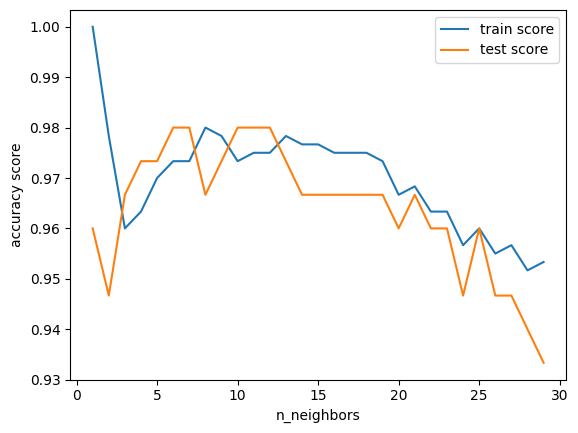

In [22]:
from sklearn.model_selection import cross_validate

n_neighbors_try = range(1, 30)

train_scores = []
test_scores = []
for n_nb in n_neighbors_try:
    cv_score = cross_validate(KNeighborsClassifier(n_neighbors=n_nb), X, y, cv=5, return_train_score=True)
    train_scores.append(cv_score["train_score"].mean())
    test_scores.append(cv_score["test_score"].mean())

plt.plot(n_neighbors_try, train_scores, label="train score")
plt.plot(n_neighbors_try, test_scores, label="test score")
plt.legend()
plt.xlabel("n_neighbors")
plt.ylabel("accuracy score")

plt.show()

Ta thấy khi `n_neighbors` quá nhỏ thì mô hình dự đoán rất tốt trên dữ liệu huấn luyện nhưng tệ trên dữ liệu kiểm tra; ta nói mô hình **quá khớp** (overfitting) dữ liệu. Ngược lại khi `n_neighbors` quá lớn thì mô hình dự đoán tệ trên cả dữ liệu huấn luyện lẫn kiểm tra; ta nói mô hình **chưa khớp** (underfitting) dữ liệu. Mục đích của việc đặt các siêu tham số là chọn được mô hình "vừa khớp" dữ liệu, từ đó chọn được mô hình tốt nhất. Khi đó mô hình cho kết quả dự đoán tốt nhất trên dữ liệu kiểm tra.

Trong ví dụ trên ta thấy giá trị tốt cho `n_neighbors` là khoảng từ 6 đến 12.

In [23]:
good_alg = KNeighborsClassifier(n_neighbors=6)
cross_val_score(good_alg, X, y, cv=5).mean()

0.9800000000000001

Ta có thể dùng các công cụ thử nghiệm tự động như `GridSearchCV` của sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) để tự động tìm giá trị tốt cho các siêu tham số (hay mô hình tốt từ tập mô hình).

In [24]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(KNeighborsClassifier(), {"n_neighbors": n_neighbors_try}, cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30)})

In [25]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'n_neighbors': 6}
0.9800000000000001
KNeighborsClassifier(n_neighbors=6)


In [26]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=6)

In [27]:
good_alg = grid_search.best_estimator_
cross_val_score(good_alg, X, y, cv=5).mean()

0.9800000000000001

**Bài tập**

Thuật toán phân lớp `LogisticRegression` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) có các siêu tham số quan trọng là `penalty`, `C`. Tìm giá trị tối ưu cho các tham số này để có bộ phân lớp `LogisticRegression` tốt nhất trên bộ dữ liệu `Iris`.

In [56]:
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

X,y = load_iris(return_X_y= True)

#grid_search = GridSearchCV(LogisticRegression(max_iter=500), {'C': [0.001, 0.01, 0.1, 1, 10,100]}, cv= 5)
#grid_search = GridSearchCV(LogisticRegression(max_iter=500), {'penalty': [11, 12, None, 'elasticnet']}, cv= 5)
grid_search = GridSearchCV(LogisticRegression(max_iter=500), {'penalty': [11, 12, None, 'elasticnet'],'C': [0.001, 0.01, 0.1, 1, 10,100]}, cv= 5)
grid_search.fit(X,y)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'C': 0.001, 'penalty': None}
0.9733333333333334
LogisticRegression(C=0.001, max_iter=500, penalty=None)


In [60]:
model = LogisticRegression(max_iter=500)
solvers = ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2', 'l1', None, 'elasticnet']
c_values = [100,10,1.0,0.1,0.01]
grid =  dict(solver = solvers, penalty = penalty, C= c_values)
grid_search = GridSearchCV(estimator=model, param_grid= grid, n_jobs=-1, cv=5, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X,y)
#print('Best %f using %s' % (grid_result.best_score_, grid_result.best_params_))

/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/pyth